In [1]:
# Learning curve for Benzene New Dataset

In [2]:
import numpy as np
from numpy import load

In [3]:
data = load('benzene2018_dft.npz')
lst = data.files
for item in lst:
    print(item)

E
name
F
theory
R
z
type
md5


In [4]:
import qml
import os
from qml.kernels import gaussian_kernel
from qml.kernels import laplacian_kernel
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from qml.math import cho_solve
import random
import matplotlib.pyplot as plt

In [6]:
# # load geometries
# compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
# for mol in compounds:
#     mol.generate_coulomb_matrix(size=12, sorting="unsorted")
# X = np.array([mol.representation for mol in compounds])

# # load energies
# energy_pbe0 = data['E']

# # Split data
# n_train = 9000
# n_test = 1000
# X_training = X[:n_train]
# Y_training = energy_pbe0[:n_train]
# X_test = X[-n_test:]
# Y_test = energy_pbe0[-n_test:]

# n_train1 = 500
# X_training1 = X[:n_train1]
# Y_training1 = energy_pbe0[:n_train1]

In [5]:
# Random Sample 1
# load geometries
compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="unsorted")
X = np.array([mol.representation for mol in compounds])

# load energies
Y = data['E']
# Y = Y - np.mean(Y) (For Centralized Data)

# Split data
X_training1, X_test1, Y_training1, Y_test1 = train_test_split(
    X, Y, train_size=9000, test_size=1000, random_state=0
)

n_train_opt = 500
n_test_opt = 100
X_training1_opt = X_training1[:n_train_opt]
Y_training1_opt = Y_training1[:n_train_opt]
X_test_opt = X_training1[-n_test_opt:]
Y_test_opt = Y_training1[-n_test_opt:]

In [6]:
Y_training1 = Y_training1.reshape(-1)

In [7]:
Y_training1_opt = Y_training1_opt.reshape(-1)

In [7]:
# HYPERPARAMETER OPTIMIZATION

In [8]:
# Hyperparameter Optimization with less trianing data with gaussian kernel of random sample 1

sigmas = []
maes_opt = []

# sigma_opt=1000
for i in range(11):
    
#     sigma_opt+=1000
    sigma_opt_new = 2**i
    sigmas.append(sigma_opt_new)
    
    # calculate kernel matrix
    sigma = sigma_opt_new
    K = gaussian_kernel(X_training1_opt, X_training1_opt, sigma)
    K[np.diag_indices_from(K)] += 1e-8

    alpha = cho_solve(K, Y_training1_opt)
    
    # Calculate a kernel matrix between test and training data, using the same sigma
    Ks = gaussian_kernel(X_test_opt, X_training1_opt, sigma)

    # Make the predictions
    Y_predicted = np.dot(Ks, alpha)

    # Calculate mean-absolute-error (MAE):
    maes_opt.append(np.mean(np.abs(Y_predicted - Y_test_opt)))

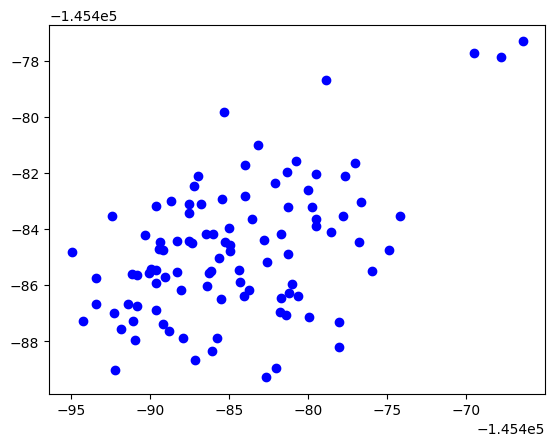

In [24]:
plt.scatter(Y_test_opt, Y_predicted, c ="blue")

In [25]:
plt.show()

Text(0, 0.5, 'Mean Absolute Error')

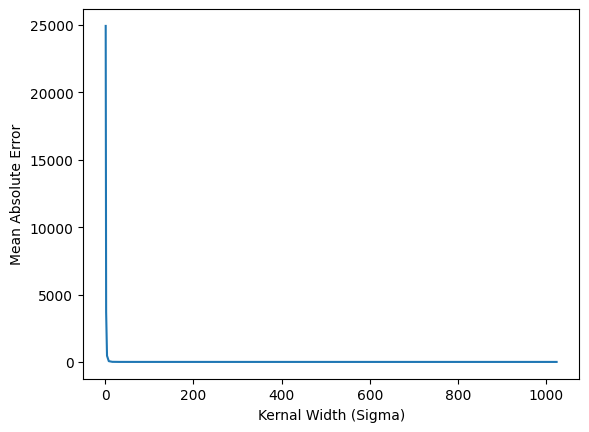

In [9]:
plt.plot(sigmas, maes_opt)
plt.xlabel("Kernal Width (Sigma)")
plt.ylabel("Mean Absolute Error")

Text(0, 0.5, 'Mean Absolute Error')

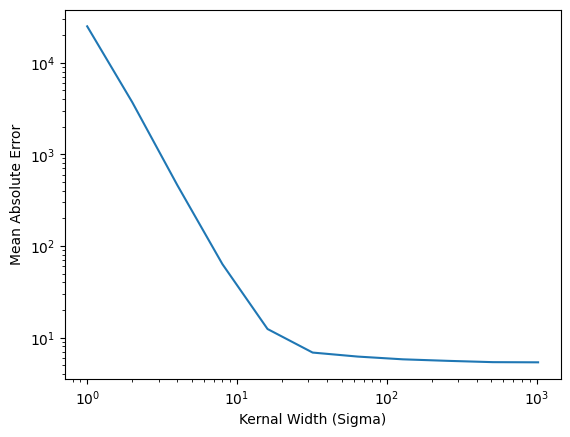

In [10]:
plt.loglog(sigmas, maes_opt)
plt.xlabel("Kernal Width (Sigma)")
plt.ylabel("Mean Absolute Error")

In [12]:
class KernelRidgeRegression:
    __doc__ = '\n kernel rigde regression \n'
    
    def __init__(self, kernel=gaussian_kernel, kernel_parameter=750, regularization=1e-8):
        self.kernel = kernel
        self.kernel_parameter = kernel_parameter
        self.regularization = regularization
        
        self.X_train = None
        self.alpha = None   
        
    def fit(self, X, Y):
            self.X_train = X
            sigma = self.kernel_parameter
            K = self.kernel(X, X, sigma)
            K[np.diag_indices_from(K)] += self.regularization
            self.alpha = cho_solve(K, Y)
            return self.alpha
        
    def predict(self, X):
            sigma = self.kernel_parameter
            K = self.kernel(X, self.X_train, sigma)
            Y_pred = np.dot(K, self.alpha)
            
            return Y_pred

In [13]:
model = KernelRidgeRegression()

In [14]:
n_samples = [2**i for i in range(1, 13)]

In [15]:
# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Sample 1 with Gaussian Kernel and sigma = 750

maes_shufflings_first = []

for i in range(5):
    # rng = random number generator
    rng = np.random.default_rng(i)
    shuffle_inds = rng.permutation(len(X_training1)) # testing data should be same

    X_training1 = X_training1[shuffle_inds]
    Y_training1 = Y_training1[shuffle_inds]
  
    maes_first = []
    for n in n_samples:
        model.fit(X_training1[:n], Y_training1[:n])
        Y_pred = model.predict(X_test1)
        mae = np.mean(np.abs(Y_pred - Y_test1))
        maes_first.append(mae)
    maes_shufflings_first.append(maes_first)

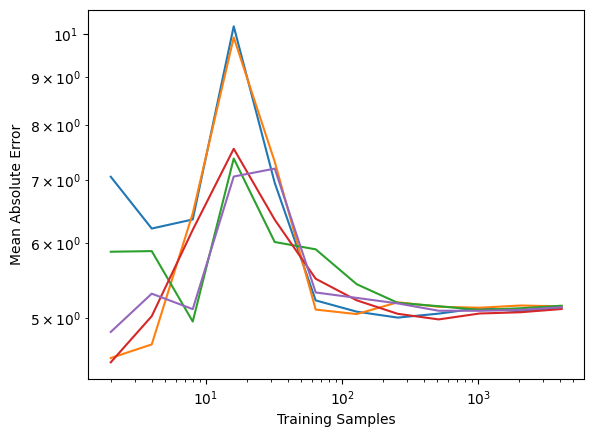

In [16]:
#Learning Curve after shuffling
for i in range(5):
    plt.loglog(n_samples, maes_shufflings_first[i])
    plt.xlabel("Training Samples")
    plt.ylabel("Mean Absolute Error")

In [17]:
maes_average_first = []

for i in range(len(n_samples)):
    
    maes_average_indexes = 0 
    for j in range(5):
        
        maes_average_indexes += maes_shufflings_first[j][i]
    maes_average_indexes = maes_average_indexes/5
    maes_average_first.append(maes_average_indexes)

Text(0, 0.5, 'Mean Absolute Error')

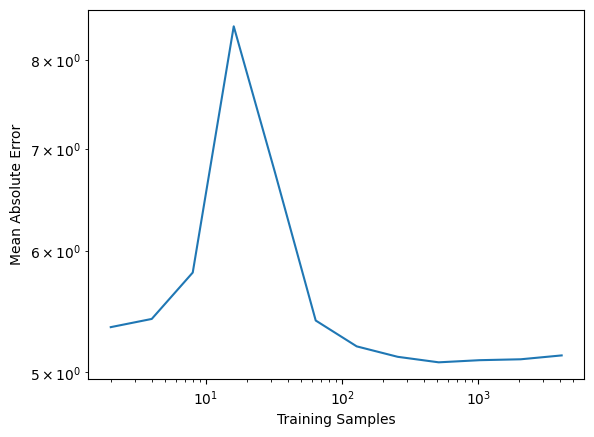

In [18]:
# Average Learning Curve for Random Sample 1 with Gaussian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_first)
plt.xlabel("Training Samples")
plt.ylabel("Mean Absolute Error")

In [19]:
# Hyperparameter Optimization with less trianing data with Laplacian kernel of random sample 1

sigmas = []
maes_opt_lap = []

# sigma_opt=0
for i in range(11):
    
#     sigma_opt+=100
    sigma_opt_new = 2**i
    sigmas.append(sigma_opt_new)
    
    # calculate kernel matrix
    sigma = sigma_opt_new
    K = laplacian_kernel(X_training1_opt, X_training1_opt, sigma)
    K[np.diag_indices_from(K)] += 1e-8

    alpha = cho_solve(K, Y_training1_opt)
    
    # Calculate a kernel matrix between test and training data, using the same sigma
    Ks = laplacian_kernel(X_test_opt, X_training1_opt, sigma)

    # Make the predictions
    Y_predicted = np.dot(Ks, alpha)

    # Calculate mean-absolute-error (MAE):
    maes_opt_lap.append(np.mean(np.abs(Y_predicted - Y_test_opt)))

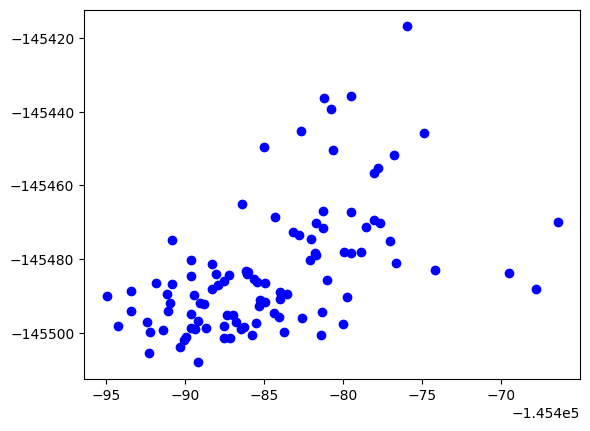

In [20]:
plt.scatter(Y_test_opt, Y_predicted, c ="blue")

Text(0, 0.5, 'Mean Absolute Error')

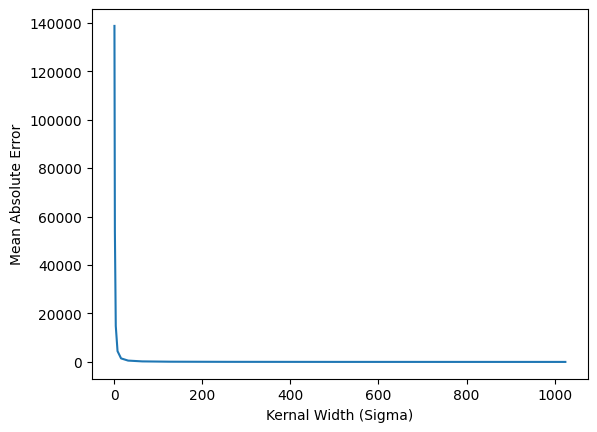

In [21]:
plt.plot(sigmas, maes_opt_lap)
plt.xlabel("Kernal Width (Sigma)")
plt.ylabel("Mean Absolute Error")

Text(0, 0.5, 'Mean Absolute Error')

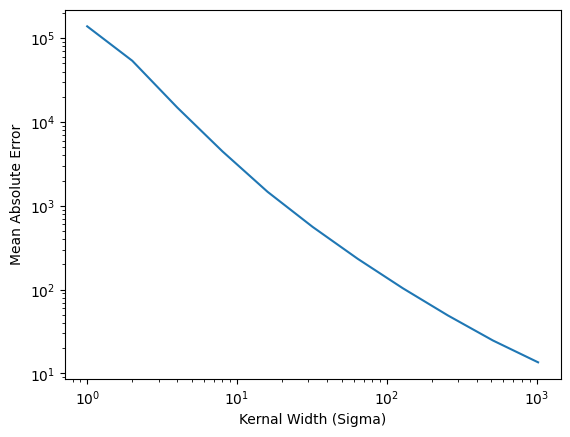

In [22]:
plt.loglog(sigmas, maes_opt_lap)
plt.xlabel("Kernal Width (Sigma)")
plt.ylabel("Mean Absolute Error")

In [23]:
class KernelRidgeRegression_lap:
    __doc__ = '\n kernel rigde regression \n'
    
    def __init__(self, kernel=laplacian_kernel, kernel_parameter=750, regularization=1e-8):
        self.kernel = kernel
        self.kernel_parameter = kernel_parameter
        self.regularization = regularization
        
        self.X_train = None
        self.alpha = None   
        
    def fit(self, X, Y):
            self.X_train = X
            sigma = self.kernel_parameter
            K = self.kernel(X, X, sigma)
            K[np.diag_indices_from(K)] += self.regularization
            self.alpha = cho_solve(K, Y)
            return self.alpha
        
    def predict(self, X):
            sigma = self.kernel_parameter
            K = self.kernel(X, self.X_train, sigma)
            Y_pred = np.dot(K, self.alpha)
            
            return Y_pred

In [24]:
model_lap = KernelRidgeRegression_lap()

In [25]:
n_samples = [2**i for i in range(1, 13)]

In [26]:
# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Sample 1 with Laplacian Kernel and sigma = 750

maes_shufflings_first_lap = []

for i in range(5):
    # rng = random number generator
    rng = np.random.default_rng(i)
    shuffle_inds = rng.permutation(len(X_training1)) # testing data should be same

    X_training1 = X_training1[shuffle_inds]
    Y_training1 = Y_training1[shuffle_inds]
  
    maes_first_lap = []
    for n in n_samples:
        model_lap.fit(X_training1[:n], Y_training1[:n])
        Y_pred = model_lap.predict(X_test1)
        mae = np.mean(np.abs(Y_pred - Y_test1))
        maes_first_lap.append(mae)
    maes_shufflings_first_lap.append(maes_first_lap)

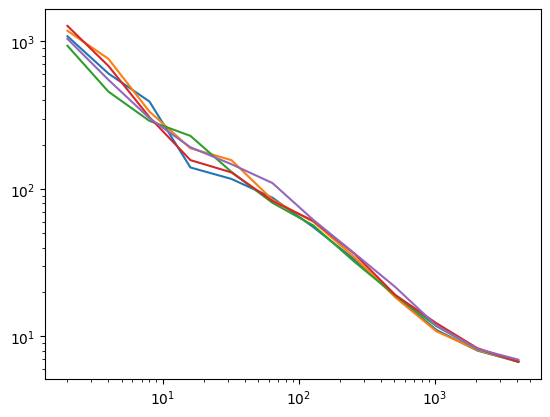

In [27]:
#Learning Curve after shuffling
for i in range(5):
    plt.loglog(n_samples, maes_shufflings_first_lap[i])

In [28]:
maes_average_first_lap = []

for i in range(len(n_samples)):
    
    maes_average_indexes = 0 
    for j in range(5):
        
        maes_average_indexes += maes_shufflings_first_lap[j][i]
    maes_average_indexes = maes_average_indexes/5
    maes_average_first_lap.append(maes_average_indexes)

Text(0, 0.5, 'Mean Absolute Error')

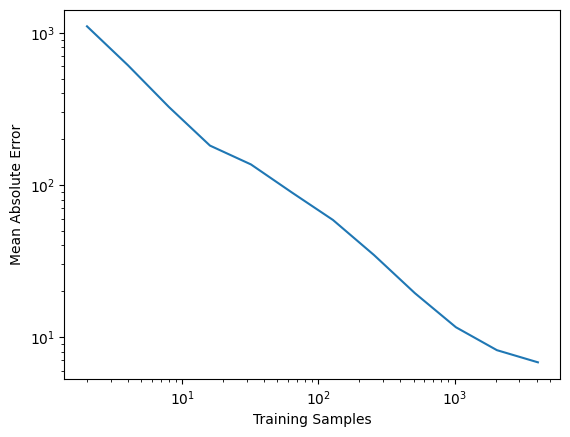

In [29]:
# Average Learning Curve for Random Sample 1 with Laplacian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_first_lap)
plt.xlabel("Training Samples")
plt.ylabel("Mean Absolute Error")

Text(0, 0.5, 'Mean Absolute Error')

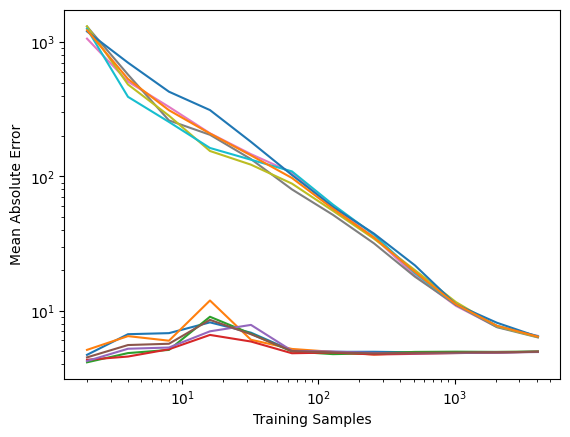

In [30]:
# Random Sample 2
# load geometries
compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="unsorted")
X = np.array([mol.representation for mol in compounds])

# load energies
Y = data['E']
# Y = Y - np.mean(Y) (For Centralized Data)


# Split data
X_training2, X_test2, Y_training2, Y_test2 = train_test_split(
X, Y, train_size=9000, test_size=1000, random_state=42
)

# n_train_opt = 500
# n_test_opt = 100
# X_training_opt = X_training[:n_train_opt]
# Y_training_opt = Y_training[:n_train_opt]
# X_test_opt = X_training[-n_test_opt:]
# Y_test_opt = Y_training[-n_test_opt:]

Y_training2 = Y_training2.reshape(-1)

class KernelRidgeRegression:
         __doc__ = '\n kernel rigde regression \n'
    
         def __init__(self, kernel=gaussian_kernel, kernel_parameter=750, regularization=1e-8):
                self.kernel = kernel
                self.kernel_parameter = kernel_parameter
                self.regularization = regularization
        
                self.X_train = None
                self.alpha = None   
        
         def fit(self, X, Y):
                    self.X_train = X
                    sigma = self.kernel_parameter
                    K = self.kernel(X, X, sigma)
                    K[np.diag_indices_from(K)] += self.regularization
                    self.alpha = cho_solve(K, Y)
                    return self.alpha
        
         def predict(self, X):
                    sigma = self.kernel_parameter
                    K = self.kernel(X, self.X_train, sigma)
                    Y_pred = np.dot(K, self.alpha)
            
                    return Y_pred
        
        
        
model = KernelRidgeRegression()
 
n_samples = [2**i for i in range(1, 13)]




# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Gaussian Kernel and sigma = 750

maes_shufflings_second = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training2)) # testing data should be same

        X_training2 = X_training2[shuffle_inds]
        Y_training2 = Y_training2[shuffle_inds]
  
        maes_second = []
        for n in n_samples:
            model.fit(X_training2[:n], Y_training2[:n])
            Y_pred = model.predict(X_test2)
            mae = np.mean(np.abs(Y_pred - Y_test2))
            maes_second.append(mae)
        maes_shufflings_second.append(maes_second)

#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_second[i])

    
    
    
maes_average_second = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
             maes_average_indexes += maes_shufflings_second[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_second.append(maes_average_indexes)
    
# Average Learning Curve for Random Samples with Gaussian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_second)

class KernelRidgeRegression_lap:
        __doc__ = '\n kernel rigde regression \n'
    
        def __init__(self, kernel=laplacian_kernel, kernel_parameter=750, regularization=1e-8):
            self.kernel = kernel
            self.kernel_parameter = kernel_parameter
            self.regularization = regularization
        
            self.X_train = None
            self.alpha = None   
        
        def fit(self, X, Y):
                self.X_train = X
                sigma = self.kernel_parameter
                K = self.kernel(X, X, sigma)
                K[np.diag_indices_from(K)] += self.regularization
                self.alpha = cho_solve(K, Y)
                return self.alpha
        
        def predict(self, X):
                sigma = self.kernel_parameter
                K = self.kernel(X, self.X_train, sigma)
                Y_pred = np.dot(K, self.alpha)
            
                return Y_pred
        
        
model_lap = KernelRidgeRegression_lap()

n_samples = [2**i for i in range(1, 13)]





# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Laplacian Kernel and sigma = 750

maes_shufflings_second_lap = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training2)) # testing data should be same

        X_training2 = X_training2[shuffle_inds]
        Y_training2 = Y_training2[shuffle_inds]
  
        maes_second_lap = []
        for n in n_samples:
            model_lap.fit(X_training2[:n], Y_training2[:n])
            Y_pred = model_lap.predict(X_test2)
            mae = np.mean(np.abs(Y_pred - Y_test2))
            maes_second_lap.append(mae)
        maes_shufflings_second_lap.append(maes_second_lap)
    
#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_second_lap[i])

    
    
maes_average_second_lap = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
            maes_average_indexes += maes_shufflings_second_lap[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_second_lap.append(maes_average_indexes)
    
# Average Learning Curve for Random Sample 2 with Laplacian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_second_lap)
plt.xlabel("Training Samples")
plt.ylabel("Mean Absolute Error")

Text(0, 0.5, 'Mean Absolute Error')

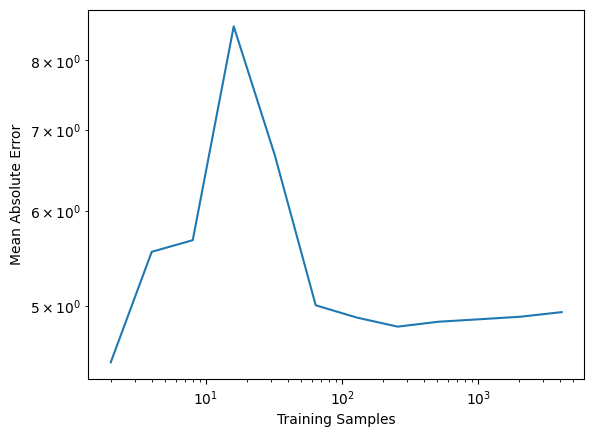

In [31]:
plt.loglog(n_samples, maes_average_second)
plt.xlabel("Training Samples")
plt.ylabel("Mean Absolute Error")

Text(0, 0.5, 'Mean Absolute Error')

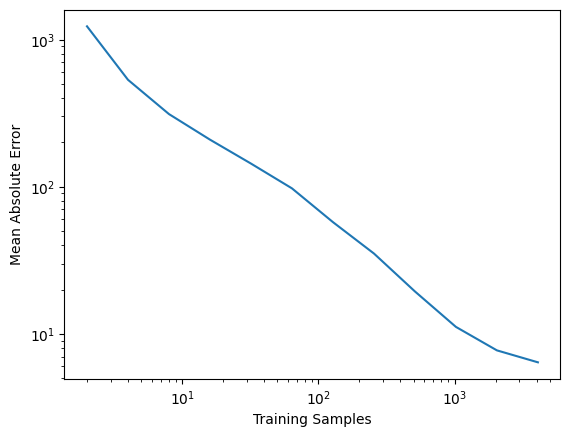

In [32]:
plt.loglog(n_samples, maes_average_second_lap)
plt.xlabel("Training Samples")
plt.ylabel("Mean Absolute Error")

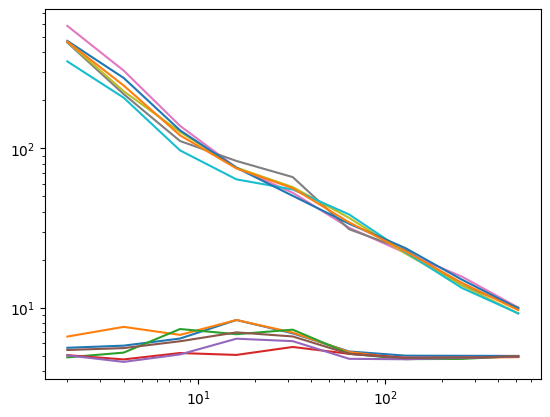

In [28]:
# Random Sample 3
# load geometries
compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="unsorted")
X = np.array([mol.representation for mol in compounds])

# load energies
Y = data['E']
# Y = Y - np.mean(Y) (For Centralized Data)


# Split data
X_training3, X_test3, Y_training3, Y_test3 = train_test_split(
X, Y, train_size=9000, test_size=1000, random_state = 11
)

# n_train_opt = 500
# n_test_opt = 100
# X_training_opt = X_training[:n_train_opt]
# Y_training_opt = Y_training[:n_train_opt]
# X_test_opt = X_training[-n_test_opt:]
# Y_test_opt = Y_training[-n_test_opt:]

Y_training3 = Y_training3.reshape(-1)

class KernelRidgeRegression:
         __doc__ = '\n kernel rigde regression \n'
    
         def __init__(self, kernel=gaussian_kernel, kernel_parameter=750, regularization=1e-8):
                self.kernel = kernel
                self.kernel_parameter = kernel_parameter
                self.regularization = regularization
        
                self.X_train = None
                self.alpha = None   
        
         def fit(self, X, Y):
                    self.X_train = X
                    sigma = self.kernel_parameter
                    K = self.kernel(X, X, sigma)
                    K[np.diag_indices_from(K)] += self.regularization
                    self.alpha = cho_solve(K, Y)
                    return self.alpha
        
         def predict(self, X):
                    sigma = self.kernel_parameter
                    K = self.kernel(X, self.X_train, sigma)
                    Y_pred = np.dot(K, self.alpha)
            
                    return Y_pred
        
        
        
model = KernelRidgeRegression()
 
n_samples = [2**i for i in range(1, 10)]




# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Gaussian Kernel and sigma = 750

maes_shufflings_third = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training3)) # testing data should be same

        X_training3 = X_training3[shuffle_inds]
        Y_training3 = Y_training3[shuffle_inds]
  
        maes_third = []
        for n in n_samples:
            model.fit(X_training3[:n], Y_training3[:n])
            Y_pred = model.predict(X_test3)
            mae = np.mean(np.abs(Y_pred - Y_test3))
            maes_third.append(mae)
        maes_shufflings_third.append(maes_third)

#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_third[i])

    
    
    
maes_average_third = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
             maes_average_indexes += maes_shufflings_third[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_third.append(maes_average_indexes)
    
# Average Learning Curve for Random Samples with Gaussian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_third)

class KernelRidgeRegression_lap:
        __doc__ = '\n kernel rigde regression \n'
    
        def __init__(self, kernel=laplacian_kernel, kernel_parameter=750, regularization=1e-8):
            self.kernel = kernel
            self.kernel_parameter = kernel_parameter
            self.regularization = regularization
        
            self.X_train = None
            self.alpha = None   
        
        def fit(self, X, Y):
                self.X_train = X
                sigma = self.kernel_parameter
                K = self.kernel(X, X, sigma)
                K[np.diag_indices_from(K)] += self.regularization
                self.alpha = cho_solve(K, Y)
                return self.alpha
        
        def predict(self, X):
                sigma = self.kernel_parameter
                K = self.kernel(X, self.X_train, sigma)
                Y_pred = np.dot(K, self.alpha)
            
                return Y_pred
        
        
model_lap = KernelRidgeRegression_lap()

n_samples = [2**i for i in range(1, 10)]





# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Laplacian Kernel and sigma = 750

maes_shufflings_third_lap = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training3)) # testing data should be same

        X_training3 = X_training3[shuffle_inds]
        Y_training3 = Y_training3[shuffle_inds]
  
        maes_third_lap = []
        for n in n_samples:
            model_lap.fit(X_training3[:n], Y_training3[:n])
            Y_pred = model_lap.predict(X_test3)
            mae = np.mean(np.abs(Y_pred - Y_test3))
            maes_third_lap.append(mae)
        maes_shufflings_third_lap.append(maes_third_lap)
    
#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_third_lap[i])

    
    
maes_average_third_lap = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
            maes_average_indexes += maes_shufflings_third_lap[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_third_lap.append(maes_average_indexes)
    
# Average Learning Curve for Random Sample 3 with Laplacian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_third_lap)  

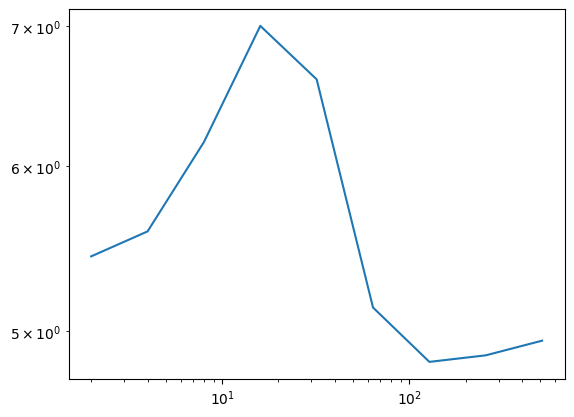

In [37]:
plt.loglog(n_samples, maes_average_third)

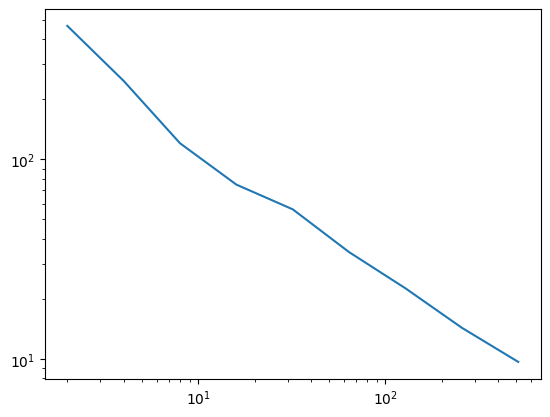

In [31]:
plt.loglog(n_samples, maes_average_third_lap)

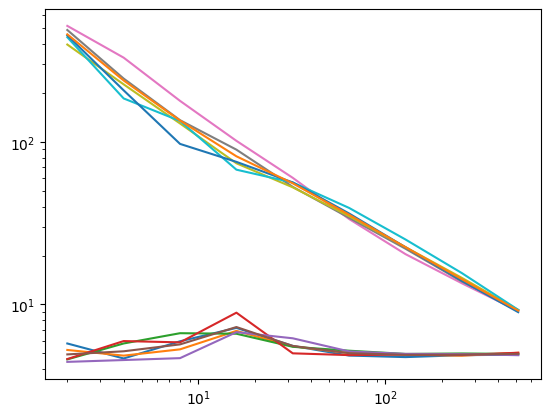

In [33]:
# Random Sample 4
# load geometries
compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="unsorted")
X = np.array([mol.representation for mol in compounds])

# load energies
Y = data['E']
# Y = Y - np.mean(Y) (For Centralized Data)


# Split data
X_training4, X_test4, Y_training4, Y_test4 = train_test_split(
X, Y, train_size=9000, test_size=1000, random_state = 91
)

# n_train_opt = 500
# n_test_opt = 100
# X_training_opt = X_training[:n_train_opt]
# Y_training_opt = Y_training[:n_train_opt]
# X_test_opt = X_training[-n_test_opt:]
# Y_test_opt = Y_training[-n_test_opt:]

Y_training4 = Y_training4.reshape(-1)

class KernelRidgeRegression:
         __doc__ = '\n kernel rigde regression \n'
    
         def __init__(self, kernel=gaussian_kernel, kernel_parameter=750, regularization=1e-8):
                self.kernel = kernel
                self.kernel_parameter = kernel_parameter
                self.regularization = regularization
        
                self.X_train = None
                self.alpha = None   
        
         def fit(self, X, Y):
                    self.X_train = X
                    sigma = self.kernel_parameter
                    K = self.kernel(X, X, sigma)
                    K[np.diag_indices_from(K)] += self.regularization
                    self.alpha = cho_solve(K, Y)
                    return self.alpha
        
         def predict(self, X):
                    sigma = self.kernel_parameter
                    K = self.kernel(X, self.X_train, sigma)
                    Y_pred = np.dot(K, self.alpha)
            
                    return Y_pred
        
        
        
model = KernelRidgeRegression()
 
n_samples = [2**i for i in range(1, 10)]




# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Gaussian Kernel and sigma = 750

maes_shufflings_fourth = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training4)) # testing data should be same

        X_training4 = X_training4[shuffle_inds]
        Y_training4 = Y_training4[shuffle_inds]
  
        maes_fourth = []
        for n in n_samples:
            model.fit(X_training4[:n], Y_training4[:n])
            Y_pred = model.predict(X_test4)
            mae = np.mean(np.abs(Y_pred - Y_test4))
            maes_fourth.append(mae)
        maes_shufflings_fourth.append(maes_fourth)

#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_fourth[i])

    
    
    
maes_average_fourth = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
             maes_average_indexes += maes_shufflings_fourth[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_fourth.append(maes_average_indexes)
    
# Average Learning Curve for Random Samples with Gaussian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_fourth)

class KernelRidgeRegression_lap:
        __doc__ = '\n kernel rigde regression \n'
    
        def __init__(self, kernel=laplacian_kernel, kernel_parameter=750, regularization=1e-8):
            self.kernel = kernel
            self.kernel_parameter = kernel_parameter
            self.regularization = regularization
        
            self.X_train = None
            self.alpha = None   
        
        def fit(self, X, Y):
                self.X_train = X
                sigma = self.kernel_parameter
                K = self.kernel(X, X, sigma)
                K[np.diag_indices_from(K)] += self.regularization
                self.alpha = cho_solve(K, Y)
                return self.alpha
        
        def predict(self, X):
                sigma = self.kernel_parameter
                K = self.kernel(X, self.X_train, sigma)
                Y_pred = np.dot(K, self.alpha)
            
                return Y_pred
        
        
model_lap = KernelRidgeRegression_lap()

n_samples = [2**i for i in range(1, 10)]





# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Laplacian Kernel and sigma = 750

maes_shufflings_fourth_lap = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training4)) # testing data should be same

        X_training4 = X_training4[shuffle_inds]
        Y_training4 = Y_training4[shuffle_inds]
  
        maes_fourth_lap = []
        for n in n_samples:
            model_lap.fit(X_training4[:n], Y_training4[:n])
            Y_pred = model_lap.predict(X_test4)
            mae = np.mean(np.abs(Y_pred - Y_test4))
            maes_fourth_lap.append(mae)
        maes_shufflings_fourth_lap.append(maes_fourth_lap)
    
#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_fourth_lap[i])

    
    
maes_average_fourth_lap = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
            maes_average_indexes += maes_shufflings_fourth_lap[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_fourth_lap.append(maes_average_indexes)
    
# Average Learning Curve for Random Sample 4 with Laplacian Kernel and sigma = 2000
plt.loglog(n_samples, maes_average_fourth_lap)  

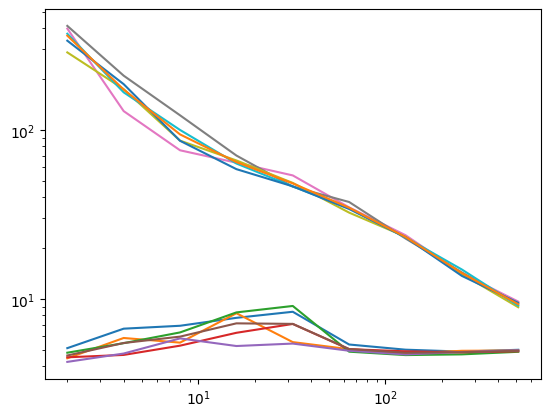

In [34]:
# Random Sample 5
# load geometries
compounds = [qml.Compound(xyz="benzenenewdatasetgeometries/"+f) for f in sorted(os.listdir("benzenenewdatasetgeometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="unsorted")
X = np.array([mol.representation for mol in compounds])

# load energies
Y = data['E']
# Y = Y - np.mean(Y) (For Centralized Data)


# Split data
X_training5, X_test5, Y_training5, Y_test5 = train_test_split(
X, Y, train_size=9000, test_size=1000, random_state = 201
)

# n_train_opt = 500
# n_test_opt = 100
# X_training_opt = X_training[:n_train_opt]
# Y_training_opt = Y_training[:n_train_opt]
# X_test_opt = X_training[-n_test_opt:]
# Y_test_opt = Y_training[-n_test_opt:]

Y_training5 = Y_training5.reshape(-1)

class KernelRidgeRegression:
         __doc__ = '\n kernel rigde regression \n'
    
         def __init__(self, kernel=gaussian_kernel, kernel_parameter=750, regularization=1e-8):
                self.kernel = kernel
                self.kernel_parameter = kernel_parameter
                self.regularization = regularization
        
                self.X_train = None
                self.alpha = None   
        
         def fit(self, X, Y):
                    self.X_train = X
                    sigma = self.kernel_parameter
                    K = self.kernel(X, X, sigma)
                    K[np.diag_indices_from(K)] += self.regularization
                    self.alpha = cho_solve(K, Y)
                    return self.alpha
        
         def predict(self, X):
                    sigma = self.kernel_parameter
                    K = self.kernel(X, self.X_train, sigma)
                    Y_pred = np.dot(K, self.alpha)
            
                    return Y_pred
        
        
        
model = KernelRidgeRegression()
 
n_samples = [2**i for i in range(1, 10)]




# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Gaussian Kernel and sigma = 750

maes_shufflings_fifth = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training5)) # testing data should be same

        X_training5 = X_training5[shuffle_inds]
        Y_training5 = Y_training5[shuffle_inds]
  
        maes_fifth = []
        for n in n_samples:
            model.fit(X_training5[:n], Y_training5[:n])
            Y_pred = model.predict(X_test5)
            mae = np.mean(np.abs(Y_pred - Y_test5))
            maes_fifth.append(mae)
        maes_shufflings_fifth.append(maes_fifth)

#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_fifth[i])

    
    
    
maes_average_fifth = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
             maes_average_indexes += maes_shufflings_fifth[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_fifth.append(maes_average_indexes)
    
# Average Learning Curve for Random Samples with Gaussian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_fifth)

class KernelRidgeRegression_lap:
        __doc__ = '\n kernel rigde regression \n'
    
        def __init__(self, kernel=laplacian_kernel, kernel_parameter=750, regularization=1e-8):
            self.kernel = kernel
            self.kernel_parameter = kernel_parameter
            self.regularization = regularization
        
            self.X_train = None
            self.alpha = None   
        
        def fit(self, X, Y):
                self.X_train = X
                sigma = self.kernel_parameter
                K = self.kernel(X, X, sigma)
                K[np.diag_indices_from(K)] += self.regularization
                self.alpha = cho_solve(K, Y)
                return self.alpha
        
        def predict(self, X):
                sigma = self.kernel_parameter
                K = self.kernel(X, self.X_train, sigma)
                Y_pred = np.dot(K, self.alpha)
            
                return Y_pred
        
        
model_lap = KernelRidgeRegression_lap()

n_samples = [2**i for i in range(1, 10)]





# Here, As we can see sigma increases the MAE decreases as far as we go




# Learning Curves of Random Samples with Laplacian Kernel and sigma = 2000

maes_shufflings_fifth_lap = []

for i in range(5):
        # rng = random number generator
        rng = np.random.default_rng(i)
        shuffle_inds = rng.permutation(len(X_training5)) # testing data should be same

        X_training5 = X_training5[shuffle_inds]
        Y_training5 = Y_training5[shuffle_inds]
  
        maes_fifth_lap = []
        for n in n_samples:
            model_lap.fit(X_training5[:n], Y_training5[:n])
            Y_pred = model_lap.predict(X_test5)
            mae = np.mean(np.abs(Y_pred - Y_test5))
            maes_fifth_lap.append(mae)
        maes_shufflings_fifth_lap.append(maes_fifth_lap)
    
#Learning Curve after shuffling
for i in range(5):
        plt.loglog(n_samples, maes_shufflings_fifth_lap[i])

    
    
maes_average_fifth_lap = []

for i in range(len(n_samples)):
    
        maes_average_indexes = 0 
        for j in range(5):
        
            maes_average_indexes += maes_shufflings_fifth_lap[j][i]
        maes_average_indexes = maes_average_indexes/5
        maes_average_fifth_lap.append(maes_average_indexes)
    
# Average Learning Curve for Random Sample 5 with Laplacian Kernel and sigma = 750
plt.loglog(n_samples, maes_average_fifth_lap)  